In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot

In [3]:
sns.set_theme(context='notebook', style='whitegrid')
palname = 'vaporwave'
pal =  sns.blend_palette(vapeplot.palette(palname), n_colors=8)

In [5]:
snow_df = (pd.read_parquet('../../data/snow_data_clean.parquet', 
                         columns=['snowfall', 'region', 'pseudo_ts', 'station',
                                 'basecol_interpolated'])
           .query('basecol_interpolated==False & snowfall<=40')
           .drop(columns=['basecol_interpolated']))
snow_df.head()

,snowfall,region,pseudo_ts,station
11088,0.0,Other,1692-01-13,Mt. Holiday
11089,0.0,Other,1692-01-14,Mt. Holiday
11090,0.0,Other,1692-01-15,Mt. Holiday
11091,0.0,Other,1692-01-16,Mt. Holiday
11092,0.0,Other,1692-01-17,Mt. Holiday


In [6]:
snow_dist_df = (snow_df.groupby(['region'],)
                .agg(mean=('snowfall', 'mean'),
                     stdv=('snowfall', 'std'))
                .reset_index(['region'])
                .sort_values(['stdv'], ascending=False)
               )
snow_dist_df

,region,mean,stdv
6,Sierras,1.512045,4.450710
7,Utah,1.751008,3.708571
0,Cascades,1.624672,3.520222
1,Colorado,1.494006,3.027847
5,Rockies_Other,1.326346,2.861909
3,New_England,0.831223,2.446666
2,East,0.654089,2.080461
4,Other,0.524662,1.839717


In [54]:
def snowfall_agg(df: pd.DataFrame, window: int) -> pd.DataFrame:
    """aggregates snowfall by amount per timeframe, and computes 
    total snow that fell on such units"""
    df = (df.groupby(['region', 'snowfall'])
          .agg(snowfall_freq=('snowfall', 'count'))
          .reset_index()
          .merge(right=station_counts, how='left', on='region',
                 copy=True, indicator=False,)
          .assign(snowfall_freq=lambda x: x.snowfall_freq/x.stations_in_reg)
          .assign(ln_snowfall_freq=lambda x: np.log(x.snowfall_freq))
          .eval('total_snow=snowfall*snowfall_freq')
          .assign(total_snow_grp=lambda x:
                  x.total_snow.rolling(window,  # win_type='triang',
                                       min_periods=0).mean())
          )
    # smoothed values are inaccurate on high curvature regions
    df.loc[0:window, 'total_snow_grp'] = df.loc[0:window, 'total_snow']
    return df

In [7]:
station_counts = (snow_df.groupby(['region'])
                 .agg(stations_in_reg=('station', lambda x: 
                                            np.size(x.unique()))))
snow_freq_df = (snow_df
                .pipe(snowfall_agg)
               )

This chart shows that the Sierras & Utah takes a much larger amount of their annual snowfall on single, large "Power Days". Colorado stations take much more of their snow in very frequent snowfalls of less than half a foot. It appears to follow a lognormal distribution, which I think is similar to plots of wind power generated annual at different speeds.

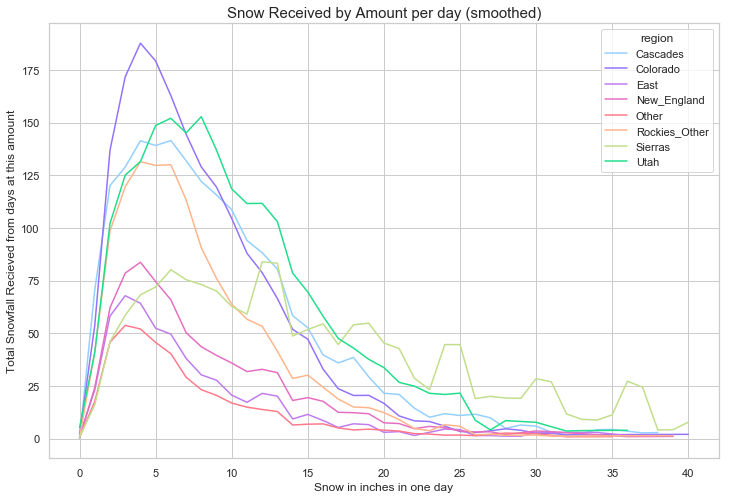

In [53]:
def snow_density_plot(df, y, freq):
    fig, ax = plt.subplots(1, figsize=(12,8))
    sns.lineplot(data=df, x='snowfall', y=y,
                 hue='region', palette=pal)
    ax.set_title(f'Snow Received by Amount per {freq} (smoothed)', size=15)
    ax.set_xlabel(f'Snow in inches in one {freq}')
    ax.set_ylabel(f'Total Snowfall Recieved from {freq}s at this amount');
snow_density_plot(df=snow_freq_df, y='total_snow_grp',
                  freq='day')

In [55]:
snow_freq_wk_df = (snow_df
                   .groupby([pd.Grouper(key='pseudo_ts', freq='W-MON'),
                             'region'])
                   .agg(snowfall=('snowfall', 'sum'))
                   .pipe(snowfall_agg, 6)
                  )

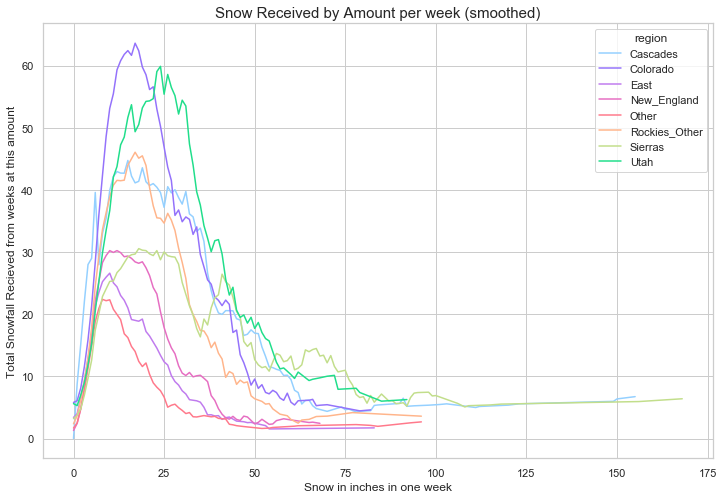

In [56]:
snow_density_plot(snow_freq_wk_df, y='total_snow_grp', freq='week')